In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')
%matplotlib inline

x_train = pd.read_csv('data/x_train_norm.csv', sep=';', na_values='?')
x_test = pd.read_csv('data/x_test_norm.csv', sep=';', na_values='?')
y_train = pd.read_csv('data/y_train.csv', sep=';', header=None, na_values='?')[0]



import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

def scorer_logloss(estimator, X, y):
    return logloss(y, estimator.predict_proba(X)[:,1])

def revert_scorer_logloss(estimator, X, y):
    return -1 * scorer_logloss(estimator, X, y)

In [4]:
n_neighbors_array = range(1, 65)
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,
                    param_grid={'n_neighbors': n_neighbors_array},
                    scoring=revert_scorer_logloss 
                   )
grid.fit(x_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function revert_scorer_logloss at 0x1145dbb90>, verbose=0)

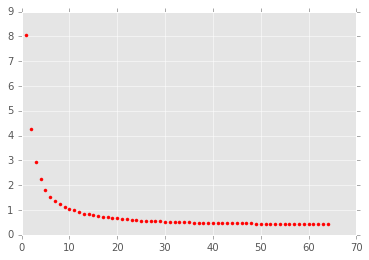

In [8]:
plt.plot(np.array(grid.cv_results_["param_n_neighbors"]), grid.cv_results_["mean_test_score"] * -1, '.r')

In [7]:
best_cv_err = -1 * grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print best_cv_err, best_n_neighbors

0.437789330714 64


In [120]:
n_neighbors = 50
classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
classifier.fit(x_train, y_train)
predict_proba = classifier.predict_proba(x_train)

In [12]:
predict

array([[ 0.54,  0.46],
       [ 0.46,  0.54],
       [ 0.94,  0.06],
       ..., 
       [ 0.92,  0.08],
       [ 0.7 ,  0.3 ],
       [ 1.  ,  0.  ]])

Найдем отпуты
http://www.ccas.ru/voron/download/MetricAlgs.pdf

In [55]:
margin = np.zeros(shape=y_train.shape)
y = np.array(y_train) # pandas.core.series.Series => numpy.ndarray
idx0 = y==0
idx1 = y==1

margin[idx0] = predict_proba[idx0,0] - predict_proba[idx0,1]
margin[idx1] = predict_proba[idx1,1] - predict_proba[idx1,0]

In [56]:
margin

array([ 0.08,  0.08, -0.88, ..., -0.84,  0.4 ,  1.  ])

получили, что 3-й объект (индекс 2) классифицируется неверно;
а последний объект (25288) - 100% верно

Проверим это

In [59]:
check_idx=2
print y[check_idx], predict_proba[check_idx], margin[check_idx]
check_idx=25288
print y[check_idx], predict_proba[check_idx], margin[check_idx]

1 [ 0.94  0.06] -0.88
0 [ 1.  0.] 1.0


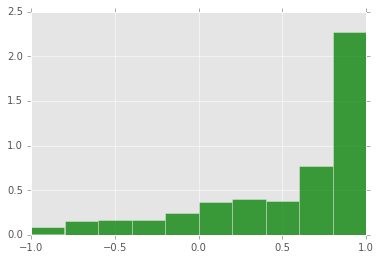

In [70]:
plt.hist(margin, 10, normed=1, facecolor='green', alpha=0.75)
plt.draw()

Удалим все выбрасы за границу примем 0

In [95]:
good_idx = margin>-0.5

In [83]:
classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
crossed = cross_val_score(classifier, x_train, y_train, scoring=revert_scorer_logloss)

In [84]:
crossed

array([-0.44219401, -0.4573191 , -0.46066146])

In [96]:
crossed = cross_val_score(classifier, x_train[good_idx], y_train[good_idx], scoring=revert_scorer_logloss)

In [97]:
crossed

array([-0.2309016 , -0.22922086, -0.22720184])

In [98]:
n_neighbors = 50
classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
classifier.fit(x_train[good_idx], y_train[good_idx])
predict_proba = classifier.predict_proba(x_train)

In [99]:
scorer_logloss(classifier, x_train, y_train)

1.3865070586698931

In [89]:
n_neighbors = 50
classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
classifier.fit(x_train, y_train)
scorer_logloss(classifier, x_train, y_train)

0.37998467558785803

In [100]:
n_neighbors_array = range(1, 65)
knn = KNeighborsClassifier()
grid = GridSearchCV(knn,
                    param_grid={'n_neighbors': n_neighbors_array},
                    scoring=revert_scorer_logloss,
                    n_jobs=3
                   )
grid.fit(x_train[good_idx], y_train[good_idx])

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function revert_scorer_logloss at 0x1145dbb90>, verbose=0)

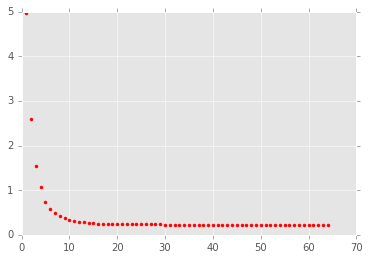

In [101]:
plt.plot(np.array(grid.cv_results_["param_n_neighbors"]), grid.cv_results_["mean_test_score"] * -1, '.r')

In [103]:
classifier = KNeighborsClassifier(n_neighbors=n_neighbors)
classifier.fit(x_train[good_idx], y_train[good_idx])
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/004_knn_50_margin_0.5.csv', sep=';', header=None, index=False)

,y
0,0.00
1,0.00
2,0.56
3,0.62
4,0.00
5,0.22
6,0.22
7,0.70
8,0.00
9,0.00


In [112]:
good_idx = margin==-1

In [113]:
good_idx

array([False, False, False, ..., False, False, False], dtype=bool)

In [114]:
x_train[good_idx]

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed,doReturnOnLowerLevels
12510,-0.917463,-0.881486,-0.367577,-0.647881,-1.555795,-0.740912,-1.338005,-0.80099,-0.872575,-0.916967,-0.621847,0
14568,-0.917463,-0.881486,-0.367577,-0.647881,-1.555795,-0.740912,-1.338005,-0.80099,-0.872575,-0.916967,-0.621847,0
15471,-0.917463,-0.881486,-0.367577,-0.647881,-1.555795,-0.740912,-1.338005,-0.80099,-0.872575,-0.916967,-0.621847,0
16416,-0.917463,-0.881486,-0.367577,-0.647881,-1.555795,-0.740912,-1.338005,-0.80099,-0.872575,-0.916967,-0.621847,0
17895,-0.917463,-0.881486,-0.367577,-0.647881,-1.555795,-0.740912,-1.338005,-0.80099,-0.872575,-0.916967,-0.621847,0


In [115]:
12510, 14568,15471

(12510, 14568, 15471)

In [128]:
xxx = pd.read_csv('data/x_train.csv', sep=';', na_values='?')
yyy = pd.read_csv('data/y_train.csv', sep=';', header=None, na_values='?')[0]

In [129]:
xxx.loc[[12510, 14568,15471]]

,maxPlayerLevel,numberOfAttemptedLevels,attemptsOnTheHighestLevel,totalNumOfAttempts,averageNumOfTurnsPerCompletedLevel,doReturnOnLowerLevels,numberOfBoostersUsed,fractionOfUsefullBoosters,totalScore,totalBonusScore,totalStarsCount,numberOfDaysActuallyPlayed
12510,0,1,1,1,3.0,0,0,0.0,163000,250,0,1
14568,0,1,1,1,3.0,0,0,0.0,163000,250,0,1
15471,0,1,1,1,3.0,0,0,0.0,163000,250,0,1


In [130]:
yyy.loc[[12510, 14568,15471]]

12510    1
14568    1
15471    1
Name: 0, dtype: int64

In [131]:
predict_proba[[12510, 14568,15471]]

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]])

In [122]:
margin[[12510, 14568,15471]]

array([-1., -1., -1.])

In [123]:
y_train[[12510, 14568,15471]]

12510    1
14568    1
15471    1
Name: 0, dtype: int64

In [126]:
yyy

,0
0,1
1,1
2,1
3,0
4,0
5,1
6,1
7,0
8,0
9,0


In [141]:
xxx.drop_duplicates().shape

(21694, 12)

In [142]:
xxx.shape

(25289, 12)

In [147]:
pd.concat((xxx, yyy), axis=1).drop_duplicates().shape

(21749, 13)

In [148]:
good_idx = margin>-0.75

In [150]:
classifier = SVC(probability=True, C=10, gamma=0.001)
classifier.fit(x_train[good_idx], y_train[good_idx])
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/003_svc_C_10_gamma_0.001_margin_-0.75.csv', sep=';', header=None, index=False)

# scorer_logloss(classifier, x_train, y_train) = 0.40327055192740419
# mlbootcamp = 0,4052715

In [152]:
good_idx = margin>-0.90

In [153]:
classifier = SVC(probability=True, C=10, gamma=0.001)
classifier.fit(x_train[good_idx], y_train[good_idx])
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/003_svc_C_10_gamma_0.001_margin_-0.90.csv', sep=';', header=None, index=False)

print scorer_logloss(classifier, x_train, y_train) #= 0.405018707392
# mlbootcamp = ???

0.405018707392


In [154]:
good_idx = margin>-0.60

In [155]:
classifier = SVC(probability=True, C=10, gamma=0.001)
classifier.fit(x_train[good_idx], y_train[good_idx])
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/003_svc_C_10_gamma_0.001_margin_-0.60.csv', sep=';', header=None, index=False)

print scorer_logloss(classifier, x_train, y_train) #= 0.423058652279
# mlbootcamp = ???

0.423058652279


In [156]:
good_idx = margin>-0.7
classifier = SVC(probability=True, C=10, gamma=0.001)
classifier.fit(x_train[good_idx], y_train[good_idx])
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/003_svc_C_10_gamma_0.001_margin_-0.70.csv', sep=';', header=None, index=False)

print scorer_logloss(classifier, x_train, y_train) #= 0.4054665436
# mlbootcamp = ???

0.4054665436


In [158]:
good_idx = margin>-0.8
classifier = SVC(probability=True, C=10, gamma=0.001)
classifier.fit(x_train[good_idx], y_train[good_idx])
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/003_svc_C_10_gamma_0.001_margin_-0.80.csv', sep=';', header=None, index=False)

print scorer_logloss(classifier, x_train, y_train) #= 0.401505454092
# mlbootcamp = ???

0.401505454092


In [159]:
good_idx = margin>-0.82
classifier = SVC(probability=True, C=10, gamma=0.001)
classifier.fit(x_train[good_idx], y_train[good_idx])
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/003_svc_C_10_gamma_0.001_margin_-0.82.csv', sep=';', header=None, index=False)

print scorer_logloss(classifier, x_train, y_train) #= 

0.400455700398


In [160]:
good_idx = margin>-0.78
classifier = SVC(probability=True, C=10, gamma=0.001)
classifier.fit(x_train[good_idx], y_train[good_idx])
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/003_svc_C_10_gamma_0.001_margin_-0.78.csv', sep=';', header=None, index=False)

print scorer_logloss(classifier, x_train, y_train) #= 

0.401460198104


In [162]:
for margin_threshold in [-0.84,-0.86, -0.88]:
    good_idx = margin > margin_threshold
    classifier = SVC(probability=True, C=10, gamma=0.001)
    classifier.fit(x_train[good_idx], y_train[good_idx])
    print margin_threshold, scorer_logloss(classifier, x_train, y_train)

-0.84 0.400449645202
-0.86 0.402614548981
-0.88 0.405025340224


In [164]:
for margin_threshold in [-0.83,-0.85]:
    good_idx = margin > margin_threshold
    classifier = SVC(probability=True, C=10, gamma=0.001)
    classifier.fit(x_train[good_idx], y_train[good_idx])
    print margin_threshold, scorer_logloss(classifier, x_train, y_train)

-0.83 0.400465467556
-0.85 0.402616629534


In [165]:
good_idx = margin>-0.84
classifier = SVC(probability=True, C=10, gamma=0.001)
classifier.fit(x_train[good_idx], y_train[good_idx])
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/003_svc_C_10_gamma_0.001_margin_-0.84.csv', sep=';', header=None, index=False)

# print scorer_logloss(classifier, x_train, y_train) #=0.400449645202
# ml = 0.402

0.400479718539


In [181]:
good_idx = margin>-0.95 #1 #0.84
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators=1200, random_state=11, n_jobs=3)
classifier.fit(x_train[good_idx], y_train[good_idx])

scorer_logloss(classifier, x_train, y_train)
#crosses = cross_val_score(classifier, x_train[good_idx], y_train[good_idx], n_jobs=3, scoring=revert_scorer_logloss)
#print np.mean(crosses), crosses

0.1592372864545705

In [180]:
y_test = classifier.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/005_rf_1200_margin_-1.csv', sep=';', header=None, index=False)

#mlbootcamp = 0,4664073

In [185]:
from sklearn.calibration import CalibratedClassifierCV
limit = 20000
good_idx = margin>-0.84

x_train_good, y_train_good = x_train[good_idx], y_train[good_idx]
xx_train, yy_train = x_train_good[:limit], y_train_good[:limit]
xx_valid, yy_valid = x_train_good[limit:], y_train_good[limit:]
clf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
clf.fit(xx_train, yy_train)
#clf_probs = clf.predict_proba(xx_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(xx_valid, yy_valid)
#sig_clf_probs = sig_clf.predict_proba(xx_test)
#sig_score = log_loss(yy_test, sig_clf_probs)

y_test = sig_clf.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/005_rf_1000_Calibrated_all_margin_-0.84.csv', sep=';', header=None, index=False)

#mlbootcamp = 0,4010898

In [186]:
from sklearn.calibration import CalibratedClassifierCV
limit = 20000
good_idx = margin>-0.95

x_train_good, y_train_good = x_train[good_idx], y_train[good_idx]
xx_train, yy_train = x_train_good[:limit], y_train_good[:limit]
xx_valid, yy_valid = x_train_good[limit:], y_train_good[limit:]
clf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
clf.fit(xx_train, yy_train)
#clf_probs = clf.predict_proba(xx_test)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid", cv="prefit")
sig_clf.fit(xx_valid, yy_valid)
#sig_clf_probs = sig_clf.predict_proba(xx_test)
#sig_score = log_loss(yy_test, sig_clf_probs)

y_test = sig_clf.predict_proba(x_test)[:,1]  # возвращается думерный массив, нас интересует 2-й стоблец
res_df = pd.DataFrame(y_test, columns = ['y'])
res_df.to_csv('res/005_rf_1000_Calibrated_all_margin_-0.95.csv', sep=';', header=None, index=False)

#mlbootcamp = 0,4005607

In [190]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f + 1, x_train.columns[idx], importances[idx]))

Feature importances:
 1. feature 'totalNumOfAttempts' (0.1584)
 2. feature 'numberOfDaysActuallyPlayed' (0.1524)
 3. feature 'averageNumOfTurnsPerCompletedLevel' (0.1302)
 4. feature 'maxPlayerLevel' (0.1052)
 5. feature 'totalScore' (0.1051)
 6. feature 'totalBonusScore' (0.0718)
 7. feature 'numberOfBoostersUsed' (0.0695)
 8. feature 'totalStarsCount' (0.0623)
 9. feature 'numberOfAttemptedLevels' (0.0486)
10. feature 'fractionOfUsefullBoosters' (0.0439)
11. feature 'attemptsOnTheHighestLevel' (0.0438)
12. feature 'doReturnOnLowerLevels' (0.0088)
